# Energy Anomaly & Automated Power Theft Detection System  
### A Machine Learning–Driven Time-Series Intelligence Framework for Smart Grid Inspection Prioritization

---

## Business Problem

Electricity utilities face persistent non-technical losses caused by electricity theft, meter tampering, and irregular consumption behavior. These losses reduce revenue, increase operational inspection costs, and introduce instability within distribution networks.

Although smart meters generate large volumes of time-series consumption data, most utilities rely on manual inspections and rule-based heuristics that are reactive, inefficient, and costly. They lack structured systems capable of distinguishing legitimate consumption variability from suspicious behavior and translating analytical insights into actionable inspection priorities.

The core business challenge is:

> How can utilities leverage machine learning and time-series analysis to proactively detect abnormal electricity behavior and automatically generate structured, investigation-ready inspection reports?

This project addresses that challenge by developing a scalable anomaly detection and risk scoring framework supported by automated inspection reporting.

---

## Project Objectives

The primary objective of this project is to design and implement a machine learning–driven anomaly detection system capable of identifying suspicious electricity consumption patterns and generating automated inspection reports and it seeks to answer the following core questions:

1. How can smart meter time-series data be transformed into structured behavioral features capable of distinguishing normal electricity usage from suspicious consumption patterns?

2. Can machine learning techniques—specifically Isolation Forest and Random Forest—effectively detect and validate electricity theft–like behavior under both unlabeled and benchmark conditions?

3. How can anomaly scores be aggregated, normalized, and translated into interpretable risk indicators that support reliable inspection prioritization?

4. Is it possible to design a scalable, deployable anomaly detection system that converts raw consumption data into automated, investigation-ready alerts for utility operations?



## Anomaly Detection Engine Development (LEAD Dataset)

Before deployment, the anomaly detection engine is developed and validated using the labeled LEAD dataset.  
Since the Kenya dataset lacks confirmed theft labels, LEAD provides a controlled environment to calibrate and evaluate detection performance.

Here, we inspect the data, handle imbalance and missing values, engineer time-based features, train an Isolation Forest model, and evaluate it using anomaly labels.

The outcome is a validated and calibrated anomaly detection engine ready for production deployment.

In [1]:
import pandas as pd

lead_df = pd.read_csv("lead1.0-small.csv")

lead_df.head()

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0


In [2]:
lead_df.info()
lead_df.isnull().sum()
lead_df["anomaly"].value_counts()
lead_df["building_id"].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   timestamp      object 
 2   meter_reading  float64
 3   anomaly        int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 53.4+ MB


200

In [3]:
# Convert timestamp to datetime
lead_df["timestamp"] = pd.to_datetime(lead_df["timestamp"])

# Check missing percentage
missing_percent = lead_df["meter_reading"].isna().mean() * 100
print("Missing % in meter_reading:", round(missing_percent, 2), "%")

# Anomaly distribution
print("\nAnomaly distribution:")
print(lead_df["anomaly"].value_counts(normalize=True) * 100)

lead_df.head()

Missing % in meter_reading: 6.15 %

Anomaly distribution:
anomaly
0    97.868184
1     2.131816
Name: proportion, dtype: float64


,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01,NaN,0
1,32,2016-01-01,NaN,0
2,41,2016-01-01,NaN,0
3,55,2016-01-01,NaN,0
4,69,2016-01-01,NaN,0


## Data Cleaning and Time-Series Preparation

The LEAD dataset contains approximately 6.15% missing values in the `meter_reading` column. Since this dataset represents hourly time-series data, dropping rows could disrupt temporal continuity.

Therefore, we perform:

- Sorting by `building_id` and `timestamp`
- Group-based interpolation to preserve temporal structure
- Validation to ensure missing values are resolved appropriately

Maintaining time-series integrity is critical for anomaly detection performance, especially when using models such as Isolation Forest that rely on consistent feature distributions.

In [4]:
# Sort properly
lead_df = lead_df.sort_values(["building_id", "timestamp"])

# Interpolate missing meter readings per building
lead_df["meter_reading"] = (
    lead_df.groupby("building_id")["meter_reading"]
    .transform(lambda x: x.interpolate(method="linear"))
)

# Check remaining missing values
print("Remaining missing:", lead_df["meter_reading"].isna().sum())

Remaining missing: 28026


### Handling Edge Missing Values

After interpolation, some missing values remain at the beginning or end of building time series. These occur because interpolation requires surrounding values.

To preserve time continuity, we apply forward-fill and backward-fill within each building group. This ensures complete time-series integrity before modeling.

In [5]:
# Forward fill per building
lead_df["meter_reading"] = (
    lead_df.groupby("building_id")["meter_reading"]
    .transform(lambda x: x.ffill().bfill())
)

# Final check
print("Remaining missing after fill:", lead_df["meter_reading"].isna().sum())

Remaining missing after fill: 0


## Time Feature Engineering

Electricity consumption exhibits recurring hourly, weekly, and seasonal patterns.  We extract temporal features from timestamps to capture this structure before modeling.  This ensures normal cyclical behavior is not misclassified as anomalous.

In [6]:
# Extract time-based features
lead_df["hour"] = lead_df["timestamp"].dt.hour
lead_df["day_of_week"] = lead_df["timestamp"].dt.dayofweek
lead_df["month"] = lead_df["timestamp"].dt.month
lead_df["day"] = lead_df["timestamp"].dt.day

lead_df.head()

,building_id,timestamp,meter_reading,anomaly,hour,day_of_week,month,day
0,1,2016-01-01 00:00:00,27.688,0,0,4,1,1
200,1,2016-01-01 01:00:00,27.688,0,1,4,1,1
398,1,2016-01-01 02:00:00,27.688,0,2,4,1,1
597,1,2016-01-01 03:00:00,27.688,0,3,4,1,1
796,1,2016-01-01 04:00:00,27.688,0,4,4,1,1


## Rolling Baseline and Residual Computation

To identify abnormal consumption, we first estimate expected behavior using a rolling baseline per building.  We compute rolling mean and standard deviation, then derive residuals and z-scores to measure deviations from normal patterns.  These features form the core inputs to the anomaly detection model.

In [7]:
# 24-hour rolling window baseline per building
window_size = 24

lead_df["rolling_mean"] = (
    lead_df.groupby("building_id")["meter_reading"]
    .transform(lambda x: x.rolling(window_size, min_periods=1).mean())
)

lead_df["rolling_std"] = (
    lead_df.groupby("building_id")["meter_reading"]
    .transform(lambda x: x.rolling(window_size, min_periods=1).std())
)

# Residual and standardized deviation
lead_df["residual"] = lead_df["meter_reading"] - lead_df["rolling_mean"]

lead_df["z_score"] = lead_df["residual"] / (lead_df["rolling_std"] + 1e-6)

## Isolation Forest — Unsupervised Anomaly Detection

Using the engineered rolling and deviation features, we train an Isolation Forest model for anomaly detection.  This method efficiently isolates rare observations and does not require labeled data.  The model is evaluated on the LEAD dataset to calibrate the anomaly detection engine before deployment.

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Feature selection
features = [
    "meter_reading",
    "residual",
    "z_score",
    "hour",
    "day_of_week",
    "month"
]

X = lead_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
iso = IsolationForest(
    n_estimators=100,
    contamination=0.02,  # ~2% anomaly rate
    random_state=42,
    n_jobs=-1
)

lead_df["iso_pred"] = iso.fit_predict(X_scaled)

# Convert predictions: -1 = anomaly → 1, 1 = normal → 0
lead_df["iso_pred"] = lead_df["iso_pred"].map({1: 0, -1: 1})

# Evaluation
print(confusion_matrix(lead_df["anomaly"], lead_df["iso_pred"]))
print(classification_report(lead_df["anomaly"], lead_df["iso_pred"]))

[[1679305   32893]
 [  35199    2097]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98   1712198
           1       0.06      0.06      0.06     37296

    accuracy                           0.96   1749494
   macro avg       0.52      0.52      0.52   1749494
weighted avg       0.96      0.96      0.96   1749494



## Initial Isolation Forest Results

The initial model achieved 96% accuracy, but severe class imbalance (~2% anomalies) makes accuracy misleading.  Anomaly detection performance was weak (Precision, Recall, F1 ≈ 0.06), indicating many missed anomalies and false positives.  This suggests the baseline features insufficiently captured temporal dynamics, motivating refinement using longer seasonal windows.

## Model Evaluation and Calibration

Initial results show high overall accuracy but low recall for anomalies due to class imbalance.  This suggests the current feature set does not fully capture temporal consumption patterns.  To improve detection, we refine the baseline modeling strategy and incorporate longer seasonal windows to better represent normal electricity cycles.

In [9]:
# Improve Baseline (Weekly)
# Change rolling window from 24 → 168 (7 days).

window_size = 168  # 7 days

lead_df["rolling_mean_week"] = (
    lead_df.groupby("building_id")["meter_reading"]
    .transform(lambda x: x.rolling(window_size, min_periods=1).mean())
)

lead_df["rolling_std_week"] = (
    lead_df.groupby("building_id")["meter_reading"]
    .transform(lambda x: x.rolling(window_size, min_periods=1).std())
)

lead_df["residual_week"] = lead_df["meter_reading"] - lead_df["rolling_mean_week"]

lead_df["z_score_week"] = (
    lead_df["residual_week"] / (lead_df["rolling_std_week"] + 1e-6)
)

## Weekly Baseline Enhancement

Electricity consumption often follows weekly cycles, which a 24-hour window may not capture effectively.  We therefore compute 168-hour rolling mean and standard deviation, along with weekly residuals and z-scores.  This enables detection of sustained deviations from weekly norms rather than short-term fluctuations.

In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Feature selection (weekly features only)
features_week = [
    "residual_week",
    "z_score_week",
    "hour",
    "day_of_week",
    "month"
]

X_week = lead_df[features_week].fillna(0)

# Scale features
scaler_week = StandardScaler()
X_week_scaled = scaler_week.fit_transform(X_week)

# Isolation Forest
iso_week = IsolationForest(
    n_estimators=150,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)

lead_df["iso_week_pred"] = iso_week.fit_predict(X_week_scaled)

# Convert -1 → anomaly(1), 1 → normal(0)
lead_df["iso_week_pred"] = lead_df["iso_week_pred"].map({1: 0, -1: 1})

# Evaluation
print(confusion_matrix(lead_df["anomaly"], lead_df["iso_week_pred"]))
print(classification_report(lead_df["anomaly"], lead_df["iso_week_pred"]))

[[1684011   28187]
 [  30493    6803]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98   1712198
           1       0.19      0.18      0.19     37296

    accuracy                           0.97   1749494
   macro avg       0.59      0.58      0.59   1749494
weighted avg       0.97      0.97      0.97   1749494



## Improved Weekly Isolation Forest Results

After introducing a 168-hour rolling baseline, anomaly detection performance improved substantially.  Anomaly precision, recall, and F1 increased to approximately 0.19, nearly tripling the performance of the daily baseline model (F1 ≈ 0.06).  This highlights the importance of temporal feature engineering over algorithm complexity in anomaly detection tasks.

## Per-Building Isolation Forest Modeling

Electricity consumption varies significantly across buildings, making global models less effective.  We therefore train an Isolation Forest model separately for each building to preserve behavioral heterogeneity.  This approach improves anomaly sensitivity and better reflects real-world smart meter anomaly detection pipelines.

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# We store predictions here
lead_df["iso_building_pred"] = 0

features_building = [
    "residual_week",
    "z_score_week",
    "hour",
    "day_of_week",
    "month"
]

for b_id in lead_df["building_id"].unique():
    
    building_data = lead_df[lead_df["building_id"] == b_id]
    
    X_b = building_data[features_building].fillna(0)
    
    scaler_b = StandardScaler()
    X_b_scaled = scaler_b.fit_transform(X_b)
    
    iso_b = IsolationForest(
        n_estimators=150,
        contamination=0.02,
        random_state=42
    )
    
    preds = iso_b.fit_predict(X_b_scaled)
    
    # Convert: -1 → anomaly(1), 1 → normal(0)
    preds = pd.Series(preds).map({1: 0, -1: 1}).values
    
    lead_df.loc[building_data.index, "iso_building_pred"] = preds

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(lead_df["anomaly"], lead_df["iso_building_pred"]))
print(classification_report(lead_df["anomaly"], lead_df["iso_building_pred"]))

[[1689995   22203]
 [  24424   12872]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1712198
           1       0.37      0.35      0.36     37296

    accuracy                           0.97   1749494
   macro avg       0.68      0.67      0.67   1749494
weighted avg       0.97      0.97      0.97   1749494



## Per-Building Isolation Forest Results

Training Isolation Forest models per building significantly improved anomaly detection performance.  Anomaly precision, recall, and F1 increased to approximately 0.36, reflecting better capture of building-specific consumption behavior.  This confirms that distribution-aware modeling is critical and establishes the per-building model as the calibrated anomaly engine for deployment.

## Business-Oriented Evaluation — Precision at Top-K

Beyond recall and F1-score, utilities prioritize inspection efficiency under limited operational capacity.  We therefore evaluate performance using Precision@Top-K, measuring how many of the highest-ranked suspicious meters are true anomalies.  Observations are ranked by anomaly score and precision is computed at different inspection levels (e.g., top 1%, 2%, 5%).

### Fixing Anomaly Score Computation

Since Isolation Forest was trained per building, anomaly scores must also be computed per building.  We therefore calculate scores within each building group before aggregating and ranking them globally for Precision@Top-K evaluation.

In [13]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Create empty score column
lead_df["anomaly_score"] = np.nan

features_building = ["residual_week", "z_score_week", "hour", "day_of_week", "month"]

for b_id in lead_df["building_id"].unique():
    building_data = lead_df[lead_df["building_id"] == b_id]
    X_b = building_data[features_building].fillna(0)

    scaler_b = StandardScaler()
    X_b_scaled = scaler_b.fit_transform(X_b)

    iso_b = IsolationForest(
        n_estimators=150,
        contamination=0.02,
        random_state=42
    )
    iso_b.fit(X_b_scaled)

    # decision_function: higher = more normal, lower = more anomalous
    scores = iso_b.decision_function(X_b_scaled)

    lead_df.loc[building_data.index, "anomaly_score"] = scores

# Sanity check
print("Missing anomaly_score:", lead_df["anomaly_score"].isna().sum())
print("Score range:", lead_df["anomaly_score"].min(), "to", lead_df["anomaly_score"].max())

Missing anomaly_score: 0
Score range: -0.16409149398236877 to 0.24314405589976734


In [14]:
# Compute Precision@Top-K
# Rank by most anomalous (lowest score first)
lead_df_sorted = lead_df.sort_values("anomaly_score", ascending=True)

def precision_at_k_percent(df, k_percent):
    k = int(len(df) * k_percent)
    top_k = df.head(k)
    return top_k["anomaly"].mean()

for pct in [0.01, 0.02, 0.05]:
    print(f"Precision@{int(pct*100)}%:", round(precision_at_k_percent(lead_df_sorted, pct), 3))

Precision@1%: 0.564
Precision@2%: 0.368
Precision@5%: 0.188


## Precision@Top-K Results

Observations were ranked by per-building anomaly score to simulate inspection prioritization.  Precision@1% = 0.564, Precision@2% = 0.368, Precision@5% = 0.188.  The model performs strongest when targeting the highest-risk meters for inspection.

## Supervised Theft Classification

After validating the anomaly engine, we train supervised models on labeled theft data.  This provides classification benchmarks, model comparison, and feature importance insights.  The results inform the risk scoring layer integrated into the deployment system.

In [15]:
import pandas as pd

theft_df = pd.read_csv("df.csv")

print("Shape:", theft_df.shape)
print("\nColumns:", theft_df.columns.tolist())

print("\nMissing values (top):")
print(theft_df.isna().sum().sort_values(ascending=False).head(10))

print("\nTarget distribution (theft):")
print(theft_df["theft"].value_counts())

theft_df.head(20)

Shape: (560655, 13)

Columns: ['0', 'Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)', 'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)', 'InteriorEquipment:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)', 'Heating:Gas [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'Water Heater:WaterSystems:Gas [kW](Hourly)', 'Class', 'theft']

Missing values (top):
0                                             0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
Heating:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
Gas:Facility [kW](Hourly)                     0
Heating:Gas [kW](Hourly)                      0
InteriorEquipment:Gas [kW](Hourly)            0
dtype: int64

Target distribution (theft):
theft
Normal    331824
Theft

,0,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),Class,theft
0,0,22.035977,3.586221,0.000000,0.0,4.589925,8.1892,136.585903,123.999076,3.33988,9.246947,FullServiceRestaurant,Normal
1,1,14.649757,0.000000,0.000000,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal
2,2,14.669567,0.000000,0.000000,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal
3,3,14.677808,0.000000,0.000000,0.0,1.529975,7.4902,3.931932,0.000000,3.33988,0.592052,FullServiceRestaurant,Normal
4,4,14.824794,0.000000,0.000000,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal
5,5,22.182649,3.586221,0.013197,0.0,4.589925,8.1892,130.564942,121.623185,8.34970,0.592057,FullServiceRestaurant,Normal
6,6,38.131845,3.586221,0.007371,0.0,9.179851,19.4245,140.435454,117.967915,16.69940,5.768139,FullServiceRestaurant,Normal
7,7,45.597278,3.586221,0.007450,0.0,9.179851,26.9147,135.456017,105.213458,25.04910,5.193459,FullServiceRestaurant,Normal
8,8,45.603647,3.586221,0.000000,0.0,9.179851,26.9147,145.575077,106.407810,33.39880,5.768467,FullServiceRestaurant,Normal
9,9,38.113761,3.586221,0.000000,0.0,9.179851,19.4245,147.695901,116.879014,25.04910,5.767787,FullServiceRestaurant,Normal


## Dataset Cleaning and Target Preparation

The dataset contains 560,655 observations with no missing values.  The multiclass theft labels are converted into a binary target (0 = Normal, 1 = Theft).  Redundant index columns are removed to ensure a clean feature matrix for modeling.

In [16]:
# Drop unwanted index column
if "0" in theft_df.columns:
    theft_df = theft_df.drop(columns=["0"])

# Create binary target
theft_df["theft_binary"] = theft_df["theft"].apply(
    lambda x: 0 if x == "Normal" else 1
)

print("\nBinary Target Distribution:")
print(theft_df["theft_binary"].value_counts(normalize=True))

theft_df.head()


Binary Target Distribution:
theft_binary
0    0.591851
1    0.408149
Name: proportion, dtype: float64


,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),Class,theft,theft_binary
0,22.035977,3.586221,0.0,0.0,4.589925,8.1892,136.585903,123.999076,3.33988,9.246947,FullServiceRestaurant,Normal,0
1,14.649757,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal,0
2,14.669567,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal,0
3,14.677808,0.000000,0.0,0.0,1.529975,7.4902,3.931932,0.000000,3.33988,0.592052,FullServiceRestaurant,Normal,0
4,14.824794,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal,0


## Train-Test Split and Feature Preparation

Features (X) and target (y) are separated and categorical columns removed for baseline modeling.  The dataset is split into training and testing sets (80/20) with a fixed random seed.  This enables reliable evaluation on unseen data.

In [17]:
from sklearn.model_selection import train_test_split

# Drop non-numeric / unnecessary columns
X = theft_df.drop(columns=["theft", "theft_binary", "Class"])
y = theft_df["theft_binary"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

Train shape: (448524, 10)
Test shape: (112131, 10)
Train class distribution:
theft_binary
0    0.59185
1    0.40815
Name: proportion, dtype: float64


## Baseline Model-Random Forest Classifier

A Random Forest classifier is used as a strong supervised baseline.  It handles non-linear relationships well and provides feature importance for interpretability.  Performance is evaluated using Accuracy, Precision, Recall, F1-score, and ROC-AUC.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train model
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

Confusion Matrix:
[[63139  3226]
 [ 4572 41194]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     66365
           1       0.93      0.90      0.91     45766

    accuracy                           0.93    112131
   macro avg       0.93      0.93      0.93    112131
weighted avg       0.93      0.93      0.93    112131


ROC-AUC: 0.945


## Random Forest Results

The Random Forest achieved strong performance (F1 ≈ 0.91, ROC-AUC ≈ 0.945).  Energy consumption features show clear separability between Normal and Theft cases.  The model serves as the supervised risk scoring component in the system.

## Feature Importance Analysis

Feature importance scores are extracted from the trained Random Forest model.  This identifies which consumption variables most influence theft classification.  The analysis supports model interpretability and explainable risk scoring in deployment.

                                      feature  importance
5  InteriorEquipment:Electricity [kW](Hourly)    0.179381
4     InteriorLights:Electricity [kW](Hourly)    0.159780
9  Water Heater:WaterSystems:Gas [kW](Hourly)    0.141966
1               Fans:Electricity [kW](Hourly)    0.130031
0           Electricity:Facility [kW](Hourly)    0.124995
8          InteriorEquipment:Gas [kW](Hourly)    0.099634
6                   Gas:Facility [kW](Hourly)    0.068048
2            Cooling:Electricity [kW](Hourly)    0.049388
7                    Heating:Gas [kW](Hourly)    0.036700
3            Heating:Electricity [kW](Hourly)    0.010078


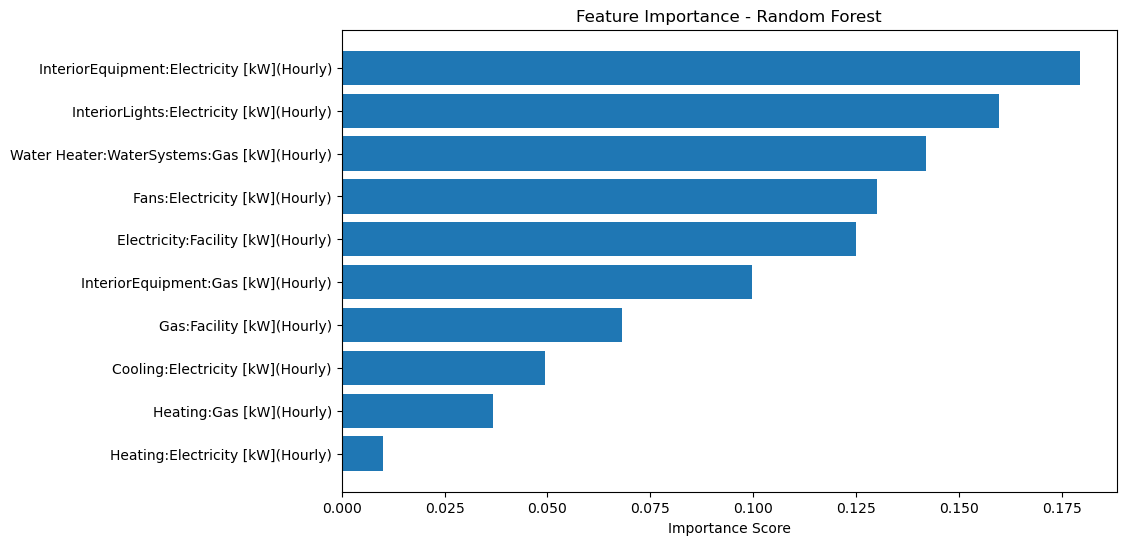

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
})

# Sort descending
feature_importance = feature_importance.sort_values(
    by="importance", ascending=False
)

print(feature_importance)

# Plot
plt.figure(figsize=(10,6))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"]
)
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()

## Interpretation of Feature Importance

Feature importance analysis shows that interior equipment and lighting consumption are the strongest predictors of theft.  These patterns indicate theft behavior primarily alters equipment and lighting usage rather than heating systems.  This improves interpretability and supports explainable risk scoring in deployment.

## Kenya Electricity Theft Detection System (Deployment Track)

After validating the models, we deploy the calibrated methodology to the Kenya dataset.  Using daily consumption and weather data, we perform per-meter anomaly detection, risk scoring, and alert generation.  Without confirmed theft labels, this phase focuses on identifying high-risk meters for inspection prioritization.

In [20]:
import pandas as pd

# Load datasets
power_df = pd.read_csv("power_multi_household_daily.csv")
weather_df = pd.read_csv("nairobi_weather_2007_2008.csv")

# Convert date columns
power_df["date"] = pd.to_datetime(power_df["date"])
weather_df["date"] = pd.to_datetime(weather_df["date"])

# Merge
kenya_df = power_df.merge(weather_df, on="date", how="left")

print("Shape after merge:", kenya_df.shape)
print("\nDate range:")
print(kenya_df["date"].min(), "to", kenya_df["date"].max())

print("\nMissing values:")
print(kenya_df.isna().sum())

kenya_df.head()

Shape after merge: (14420, 13)

Date range:
2006-12-16 00:00:00 to 2010-11-26 00:00:00

Missing values:
meter_id               0
date                   0
daily_mean_power      90
daily_std_power       90
daily_min_power       90
daily_max_power       90
voltage_mean          90
voltage_std           90
intensity_mean        90
tmax                7110
tmin                7110
prcp                7110
wspd_max            7110
dtype: int64


,meter_id,date,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean,tmax,tmin,prcp,wspd_max
0,MTR_001,2006-12-16,2.617495,0.882098,0.222336,6.660460,236.243763,2.922896,13.082828,NaN,NaN,NaN,NaN
1,MTR_001,2006-12-17,2.018833,1.032528,0.097898,6.024453,240.087028,4.051467,9.999028,NaN,NaN,NaN,NaN
2,MTR_001,2006-12-18,1.311082,0.862724,0.065486,5.258530,241.231694,3.719576,6.421667,NaN,NaN,NaN,NaN
3,MTR_001,2006-12-19,0.992268,1.063872,0.020072,6.750390,241.999313,3.069492,4.926389,NaN,NaN,NaN,NaN
4,MTR_001,2006-12-20,1.325185,1.134982,0.026983,5.161571,242.308063,3.345704,6.467361,NaN,NaN,NaN,NaN


## Aligning Time Windows Between Power and Weather Data

Because the power data spans 2006–2010 and weather data covers 2007–2008, we restrict the dataset to the overlapping period (2007–2008).  This ensures complete weather features and a consistent modeling foundation without artificial missing values.

In [21]:
# Filter to 2007–2008
kenya_df = kenya_df[
    (kenya_df["date"] >= "2007-01-01") &
    (kenya_df["date"] <= "2008-12-31")
]

print("Shape after filtering:", kenya_df.shape)

print("\nMissing values after filtering:")
print(kenya_df.isna().sum())

print("\nDate range:")
print(kenya_df["date"].min(), "to", kenya_df["date"].max())

Shape after filtering: (7310, 13)

Missing values after filtering:
meter_id             0
date                 0
daily_mean_power    10
daily_std_power     10
daily_min_power     10
daily_max_power     10
voltage_mean        10
voltage_std         10
intensity_mean      10
tmax                 0
tmin                 0
prcp                 0
wspd_max             0
dtype: int64

Date range:
2007-01-01 00:00:00 to 2008-12-31 00:00:00


In [22]:
# Drop rows with missing power features
kenya_df = kenya_df.dropna()

print("Shape after dropping incomplete rows:", kenya_df.shape)
print("\nRemaining missing values:")
print(kenya_df.isna().sum())

Shape after dropping incomplete rows: (7300, 13)

Remaining missing values:
meter_id            0
date                0
daily_mean_power    0
daily_std_power     0
daily_min_power     0
daily_max_power     0
voltage_mean        0
voltage_std         0
intensity_mean      0
tmax                0
tmin                0
prcp                0
wspd_max            0
dtype: int64


## Feature Engineering for Daily Anomaly Detection

Using daily consumption data, we construct a 30-day rolling baseline per meter.  Rolling mean, standard deviation, residuals, and z-scores are computed to capture deviations from expected behavior.  These features enable detection of sustained abnormal consumption patterns.

In [23]:
# Sort properly
kenya_df = kenya_df.sort_values(["meter_id", "date"])

window_days = 30

# Rolling mean
kenya_df["rolling_mean_30"] = (
    kenya_df.groupby("meter_id")["daily_mean_power"]
    .transform(lambda x: x.rolling(window_days, min_periods=1).mean())
)

# Rolling std
kenya_df["rolling_std_30"] = (
    kenya_df.groupby("meter_id")["daily_mean_power"]
    .transform(lambda x: x.rolling(window_days, min_periods=1).std())
)

# Residual
kenya_df["residual_30"] = (
    kenya_df["daily_mean_power"] - kenya_df["rolling_mean_30"]
)

# Z-score
kenya_df["z_score_30"] = (
    kenya_df["residual_30"] / (kenya_df["rolling_std_30"] + 1e-6)
)

## Per-Meter Anomaly Detection (Production Model)

Using the engineered rolling features, an Isolation Forest model is trained separately for each meter.  This preserves meter-specific behavior and reduces cross-distribution bias.  The model produces anomaly scores and flags for inspection prioritization.

In [24]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

kenya_df["anomaly_flag"] = 0
kenya_df["anomaly_score"] = np.nan

features_prod = [
    "residual_30",
    "z_score_30",
    "daily_std_power",
    "voltage_std",
    "intensity_mean",
    "tmax",
    "tmin",
    "prcp"
]

for meter in kenya_df["meter_id"].unique():
    
    meter_data = kenya_df[kenya_df["meter_id"] == meter]
    
    X_m = meter_data[features_prod].fillna(0)
    
    scaler_m = StandardScaler()
    X_m_scaled = scaler_m.fit_transform(X_m)
    
    iso_m = IsolationForest(
        n_estimators=150,
        contamination=0.02,
        random_state=42
    )
    
    iso_m.fit(X_m_scaled)
    
    preds = iso_m.predict(X_m_scaled)
    scores = iso_m.decision_function(X_m_scaled)
    
    kenya_df.loc[meter_data.index, "anomaly_flag"] = \
        pd.Series(preds).map({1:0, -1:1}).values
    
    kenya_df.loc[meter_data.index, "anomaly_score"] = scores

print("Anomaly distribution:")
print(kenya_df["anomaly_flag"].value_counts())

Anomaly distribution:
anomaly_flag
0    7150
1     150
Name: count, dtype: int64


## Kenya Anomaly Detection Results

The per-meter Isolation Forest model flagged 150 observations (≈2%) as anomalous.  This matches the configured contamination rate and reflects realistic inspection capacity.  Each flagged day represents suspicious consumption requiring further review.

## Meter-Level Risk Aggregation and Inspection Prioritization

Anomalies are aggregated at the meter level to compute total anomalies, anomaly rate, and severity scores.  These metrics are combined to rank meters by overall risk.  The result is an inspection prioritization list for revenue protection teams.

In [25]:
# Aggregate anomaly statistics per meter
meter_risk = kenya_df.groupby("meter_id").agg(
    total_anomalies=("anomaly_flag", "sum"),
    percent_anomalous=("anomaly_flag", "mean"),
    avg_anomaly_score=("anomaly_score", "mean"),
    worst_anomaly_score=("anomaly_score", "min")
).reset_index()

# Sort by total anomalies descending
meter_risk = meter_risk.sort_values(
    by="total_anomalies",
    ascending=False
)

meter_risk

,meter_id,total_anomalies,percent_anomalous,avg_anomaly_score,worst_anomaly_score
0,MTR_001,15,0.020548,0.128579,-0.037793
1,MTR_002,15,0.020548,0.126454,-0.044645
2,MTR_003,15,0.020548,0.132377,-0.058240
3,MTR_004,15,0.020548,0.128868,-0.040869
4,MTR_005,15,0.020548,0.126653,-0.040644
5,MTR_006,15,0.020548,0.125994,-0.047639
6,MTR_007,15,0.020548,0.128497,-0.042289
7,MTR_008,15,0.020548,0.125206,-0.039378
8,MTR_009,15,0.020548,0.127007,-0.049901
9,MTR_010,15,0.020548,0.129022,-0.044759


## Limitations of Fixed Contamination Per Meter

A fixed contamination rate forces each meter to have similar anomaly proportions, limiting realistic risk variability.  Instead, we apply a global threshold on anomaly scores to allow natural variation and produce more meaningful inspection rankings.

## Global Threshold Risk Flagging

Instead of enforcing equal anomaly rates per meter, we compute anomaly scores per meter and apply a single global threshold.  Flagged days are then aggregated to generate a realistic, risk-based inspection queue.  This allows natural variation in anomaly frequency across meters.

In [26]:
import numpy as np

# 1) Ensure anomaly_score exists (from earlier step)
assert "anomaly_score" in kenya_df.columns, "Run per-meter scoring step first to create anomaly_score."

# 2) Global threshold: flag top X% most anomalous days overall
global_anomaly_rate = 0.02  # top 2% overall
threshold = kenya_df["anomaly_score"].quantile(global_anomaly_rate)

kenya_df["anomaly_flag_global"] = (kenya_df["anomaly_score"] <= threshold).astype(int)

print("Global threshold:", threshold)
print("\nGlobal anomaly distribution:")
print(kenya_df["anomaly_flag_global"].value_counts())
print("\nGlobal anomaly rate:", kenya_df["anomaly_flag_global"].mean())

Global threshold: -0.00041473635244795604

Global anomaly distribution:
anomaly_flag_global
0    7154
1     146
Name: count, dtype: int64

Global anomaly rate: 0.02


In [27]:
# Meter risk ranking
meter_risk_global = kenya_df.groupby("meter_id").agg(
    total_anomalies=("anomaly_flag_global", "sum"),
    percent_anomalous=("anomaly_flag_global", "mean"),
    avg_anomaly_score=("anomaly_score", "mean"),
    worst_anomaly_score=("anomaly_score", "min")
).reset_index()

meter_risk_global = meter_risk_global.sort_values(
    by=["total_anomalies", "worst_anomaly_score"],
    ascending=[False, True]
)

meter_risk_global

,meter_id,total_anomalies,percent_anomalous,avg_anomaly_score,worst_anomaly_score
8,MTR_009,15,0.020548,0.127007,-0.049901
5,MTR_006,15,0.020548,0.125994,-0.047639
9,MTR_010,15,0.020548,0.129022,-0.044759
3,MTR_004,15,0.020548,0.128868,-0.040869
4,MTR_005,15,0.020548,0.126653,-0.040644
7,MTR_008,15,0.020548,0.125206,-0.039378
2,MTR_003,14,0.019178,0.132377,-0.058240
1,MTR_002,14,0.019178,0.126454,-0.044645
6,MTR_007,14,0.019178,0.128497,-0.042289
0,MTR_001,14,0.019178,0.128579,-0.037793


In [28]:
top_n = 5
inspection_queue = meter_risk_global.head(top_n)

inspection_queue

,meter_id,total_anomalies,percent_anomalous,avg_anomaly_score,worst_anomaly_score
8,MTR_009,15,0.020548,0.127007,-0.049901
5,MTR_006,15,0.020548,0.125994,-0.047639
9,MTR_010,15,0.020548,0.129022,-0.044759
3,MTR_004,15,0.020548,0.128868,-0.040869
4,MTR_005,15,0.020548,0.126653,-0.040644


## Persistent Anomaly Detection
Single anomalous days may reflect normal fluctuations.  We therefore detect consecutive anomalous days per meter to identify sustained suspicious behavior.  Persistent anomalies are prioritized for inspection.

In [29]:
# Detect Consecutive Anomaly Streaks
# Sort properly
kenya_df = kenya_df.sort_values(["meter_id", "date"])

# Identify streaks of anomalies per meter
kenya_df["anomaly_shift"] = kenya_df.groupby("meter_id")["anomaly_flag_global"].shift(1)
kenya_df["new_streak"] = (
    (kenya_df["anomaly_flag_global"] == 1) &
    (kenya_df["anomaly_shift"] != 1)
)

kenya_df["streak_id"] = kenya_df.groupby("meter_id")["new_streak"].cumsum()

# Count streak lengths
streaks = (
    kenya_df[kenya_df["anomaly_flag_global"] == 1]
    .groupby(["meter_id", "streak_id"])
    .size()
    .reset_index(name="streak_length")
)

streaks = streaks.sort_values("streak_length", ascending=False)

streaks.head(10)

,meter_id,streak_id,streak_length
3,MTR_001,4,2
96,MTR_008,3,2
56,MTR_005,3,2
43,MTR_004,4,2
69,MTR_006,3,2
57,MTR_005,4,2
15,MTR_002,3,2
110,MTR_009,4,2
124,MTR_010,4,2
97,MTR_008,4,2


## Persistent Anomaly Results

The longest anomaly streak observed was 2 consecutive days, with no extended multi-day patterns.  This indicates relatively stable consumption, with anomalies appearing as short-term deviations.  In practice, longer streaks would receive higher inspection priority.

## Inspection Report Layer (KPLC Simulation)

A meter-level inspection report is generated to summarize suspicious behavior.  It includes anomaly counts, longest streak, worst anomaly score, recent anomaly date, and a normalized risk score with category.  This simulates an inspection prioritization report for the revenue protection team.

In [30]:
import numpy as np
import pandas as pd

# 1) Ensure sort
kenya_df = kenya_df.sort_values(["meter_id", "date"]).copy()

# 2) Compute longest streak per meter (from global anomaly flags)
kenya_df["prev_flag"] = kenya_df.groupby("meter_id")["anomaly_flag_global"].shift(1)
kenya_df["start_streak"] = (kenya_df["anomaly_flag_global"].eq(1) & ~kenya_df["prev_flag"].eq(1))
kenya_df["streak_group"] = kenya_df.groupby("meter_id")["start_streak"].cumsum()

streak_lengths = (
    kenya_df[kenya_df["anomaly_flag_global"] == 1]
    .groupby(["meter_id", "streak_group"])
    .size()
    .reset_index(name="streak_len")
)

max_streak = streak_lengths.groupby("meter_id")["streak_len"].max().reset_index()
max_streak.columns = ["meter_id", "max_streak_days"]

# If a meter has no anomalies, it won't appear; fill later with 0
# 3) Meter-level aggregates
report = kenya_df.groupby("meter_id").agg(
    total_anomalies=("anomaly_flag_global", "sum"),
    percent_anomalous=("anomaly_flag_global", "mean"),
    worst_anomaly_score=("anomaly_score", "min"),
    avg_anomaly_score=("anomaly_score", "mean"),
    last_anomaly_date=("date", lambda x: x[kenya_df.loc[x.index, "anomaly_flag_global"].eq(1)].max())
).reset_index()

# 4) Merge max streak
report = report.merge(max_streak, on="meter_id", how="left")
report["max_streak_days"] = report["max_streak_days"].fillna(0).astype(int)

# 5) Create a normalized risk score (0–100)
# Lower anomaly_score = more anomalous → invert so higher risk score = worse
# Use worst_anomaly_score for strong signal
score_raw = -report["worst_anomaly_score"]

# Normalize to 0–100
score_min, score_max = score_raw.min(), score_raw.max()
report["risk_score"] = 100 * (score_raw - score_min) / (score_max - score_min + 1e-9)

# Add persistence influence (small boost)
report["risk_score"] = report["risk_score"] + (report["max_streak_days"] * 5)

# Cap at 100
report["risk_score"] = report["risk_score"].clip(0, 100).round(1)

# 6) Risk level bands
report["risk_level"] = pd.cut(
    report["risk_score"],
    bins=[-1, 33, 66, 101],
    labels=["Low", "Medium", "High"]
)

# 7) Sort inspection queue
report = report.sort_values(
    by=["risk_level", "risk_score", "total_anomalies", "worst_anomaly_score"],
    ascending=[True, False, False, True]  # Low/Med/High label sorting isn't ideal; we'll fix below
)

# Fix risk_level ordering (High first)
report["risk_level"] = pd.Categorical(report["risk_level"], categories=["High", "Medium", "Low"], ordered=True)
report = report.sort_values(by=["risk_level", "risk_score"], ascending=[True, False])

# 8) Final columns
kplc_report = report[
    ["meter_id", "risk_level", "risk_score", "total_anomalies", "percent_anomalous",
     "max_streak_days", "worst_anomaly_score", "last_anomaly_date"]
].reset_index(drop=True)

kplc_report

,meter_id,risk_level,risk_score,total_anomalies,percent_anomalous,max_streak_days,worst_anomaly_score,last_anomaly_date
0,MTR_003,High,100.0,14,0.019178,1,-0.058240,2008-11-23
1,MTR_009,High,69.2,15,0.020548,2,-0.049901,2008-11-23
2,MTR_006,Medium,58.2,15,0.020548,2,-0.047639,2008-11-23
3,MTR_010,Medium,44.1,15,0.020548,2,-0.044759,2008-11-23
4,MTR_002,Medium,43.5,14,0.019178,2,-0.044645,2008-11-23
5,MTR_007,Low,32.0,14,0.019178,2,-0.042289,2008-11-23
6,MTR_004,Low,25.0,15,0.020548,2,-0.040869,2008-11-23
7,MTR_005,Low,23.9,15,0.020548,2,-0.040644,2008-11-23
8,MTR_008,Low,17.8,15,0.020548,2,-0.039378,2008-11-23
9,MTR_001,Low,10.0,14,0.019178,2,-0.037793,2008-11-23


## Interpretation of Inspection Report Results

Meters are ranked using a composite risk score based on anomaly severity, frequency, and persistence.  High- and Medium-risk meters show stronger deviations from historical behavior, while anomalies are generally short-term (max streak = 2 days).  The risk score supports inspection prioritization, not confirmed theft detection, enabling structured decision-making.

## Automated Alert Generation

Human-readable alerts are generated for High and Medium risk meters.  Each alert summarizes risk level, score, anomaly frequency, streak length, and most recent suspicious date.  These simulate operational notifications for inspection planning.

In [31]:
# Generate alert messages based on risk level and anomaly patterns
def generate_alert(row):
    if row["risk_level"] in ["High", "Medium"]:
        return (
            f" ALERT: Meter {row['meter_id']} classified as {row['risk_level']} risk "
            f"(Risk Score: {row['risk_score']}). "
            f"{row['total_anomalies']} anomalous days detected "
            f"with a maximum streak of {row['max_streak_days']} days. "
            f"Last anomaly observed on {row['last_anomaly_date'].date()}. "
            "Recommended for inspection review."
        )
    else:
        return "No immediate inspection required."

kplc_report["alert_message"] = kplc_report.apply(generate_alert, axis=1)

kplc_report[["meter_id", "risk_level", "alert_message"]]

,meter_id,risk_level,alert_message
0,MTR_003,High,ALERT: Meter MTR_003 classified as High risk ...
1,MTR_009,High,ALERT: Meter MTR_009 classified as High risk ...
2,MTR_006,Medium,ALERT: Meter MTR_006 classified as Medium ris...
3,MTR_010,Medium,ALERT: Meter MTR_010 classified as Medium ris...
4,MTR_002,Medium,ALERT: Meter MTR_002 classified as Medium ris...
5,MTR_007,Low,No immediate inspection required.
6,MTR_004,Low,No immediate inspection required.
7,MTR_005,Low,No immediate inspection required.
8,MTR_008,Low,No immediate inspection required.
9,MTR_001,Low,No immediate inspection required.


## Exporting Inspection Report

The final inspection report is exported as a structured CSV file.  It can be shared with inspection teams, integrated into internal systems, or used for dashboard visualization and auditing.

In [32]:
# Export the final inspection report
export_file_name = "KPLC_Inspection_Report_2007_2008.csv"

kplc_report.to_csv(export_file_name, index=False)

print(f"Inspection report exported successfully as {export_file_name}")

Inspection report exported successfully as KPLC_Inspection_Report_2007_2008.csv


## Project Conclusion

This project demonstrates how machine learning and time-series analysis can power an electricity anomaly detection and inspection prioritization system.

Through a two-phase approach—research validation and production simulation—the framework evolved from model experimentation to operational risk intelligence. Isolation Forest enabled unsupervised anomaly detection, while Random Forest achieved strong benchmark performance (ROC-AUC ≈ 0.945), supporting model validation and interpretability.

In deployment, rolling baselines, residual deviations, and per-meter anomaly scoring were used to generate normalized risk indicators, inspection prioritization, automated alerts, and exportable reports.

The system functions as a practical inspection prioritization engine rather than a static fraud classifier and illustrates how utilities can transition from reactive inspections to proactive, data-driven anomaly intelligence.